In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob

# Tricking your cerebellum with a reaching task
# Exercise 1 – Perturbation & after-effect

By: Robin Uhrich* and Ieva Kerseviciute*

*equal contribution

## Task 1: Implementation of perturbation

- Implement a sudden clockwise perturbation of 30°
- Implement a gradual counterclockwise perturbation of 3° (10 steps, 3 attempts each)

```python
# TASK1: CALCULATE perturbed_mouse_pos
# PRESS 'h' in game for a hint
if perturbation_mode:
    if perturbation_type == "sudden":
        # sudden clockwise perturbation of perturbation_angle
        # 30 degree
        perturbed_mouse_angle = perturbation_angle

    elif perturbation_type == "gradual":
        # gradual counterclockwise perturbation of perturbation_angle in 10 steps, with perturbation_angle/10, each step lasts 3 attempts
        perturbed_mouse_angle = np.deg2rad(((gradual_attempts // 3) + 1) * np.rad2deg(perturbation_angle) / 10)
    
    rot_mat = np.array([[np.cos(perturbed_mouse_angle), -np.sin(perturbed_mouse_angle)],
                        [np.sin(perturbed_mouse_angle), np.cos(perturbed_mouse_angle)]])
    perturbed_mouse_pos = rot_mat @ (np.array(mouse_pos) - START_POSITION) + START_POSITION 
    circle_pos = perturbed_mouse_pos.tolist()
else:
    circle_pos = pygame.mouse.get_pos()
```

## Task 2: Analysis of experiment on unbiased subjects

- Calculate the signed error_angles between target and circle cursor, exclude slow attempts where "MOVE FASTER" appeared.
- Plot the error angles over all attempts and highlight the experiment segments.
- What is the motor variability (MV) in the unperturbed segments?
- Run the experiment a second time with `mask_mode = false`. What do you observe in subject's movements in the now unmasked part?


For this task only attempts until 200 are interesting. The rest can be ignored for now. 

In [105]:
experiment = pd.DataFrame({
    "Attempt": [1, 40, 80, 120, 160, 200, 240, 280, 320],
    "AttemptEnd": np.array([40, 80, 120, 160, 200, 240, 280, 320, 361]) - 1,
    "Perturbation": [
        "No perturbation", "Gradual",
        "No perturbation", "Sudden",
        "No perturbation", "Gradual reversed",
        "No perturbation", "Sudden reversed",
        "No perturbation"
    ]
})

n_attempts = 340

attempts = list(range(1, n_attempts + 1))

perturbations = []
for i in range(len(experiment)):
    start = experiment["Attempt"][i]
    end = experiment["Attempt"][i + 1] if i + 1 < len(experiment) else n_attempts + 1
    perturbations.extend([experiment["Perturbation"][i]] * (end - start))

full_experiment = pd.DataFrame({ "Attempt": attempts, "Perturbation": perturbations })

In [106]:
def read_data(filename):
    res = np.load(filename, allow_pickle = True)
    return pd.DataFrame({
        "MoveFaster": res.item()["move_faster_logs"],
        "ErrorAngle": res.item()["error_angle_logs"],
        "Time": res.item()["time_logs"],
        "Attempt": np.arange(len(res.item()["move_faster_logs"])) + 1
    })


def preprocess(data, design):
    # Merge with experimental design describing perturbation conditions
    data = pd.merge(data, design)
    
    # Remove trials where move faster appeared
    data = data[data.MoveFaster == 0]
    data.reset_index(drop = True, inplace = True)

    return data


def evaluate_statistics(data):
    statistics = []

    for _, change in experiment.iterrows():
        selected_data = data[(data.Attempt >= change.Attempt) & (data.Attempt <= change.AttemptEnd)]
        error_angle = selected_data.ErrorAngle.to_numpy()
        error_angle = error_angle[~selected_data.MoveFaster.to_numpy().astype(bool)]

        statistics.append(pd.DataFrame({
            "Perturbation": change.Perturbation,
            "ErrorAngleStd": [error_angle.std()],
            "ErrorAngleMean": [error_angle.mean()],
            "TimeStd": [selected_data.Time.std()],
            "TimeMean": [selected_data.Time.mean()]
        }))

    statistics = pd.concat(statistics, ignore_index = True)

    return statistics

In [107]:
def plot_error_angle(subjects, experiment, stats):
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

    color_map = mpl.colormaps["autumn"]
    n_colors = len(experiment.Perturbation.unique())
    colors = [color_map(idx / (n_colors - 1)) for idx in range(n_colors)]
    colors = dict(zip(experiment.Perturbation.unique(), colors))
    unique_periods = experiment.Perturbation.unique()

    # Show the different experimental periods
    for i, change in experiment.iterrows():
        label = change.Perturbation if change.Perturbation in unique_periods else ""
        unique_periods = unique_periods[unique_periods != change.Perturbation]

        start = change.Attempt
        end = change.AttemptEnd

        axs[0].axvspan(
            start, end,
            alpha = 0.2,
            label = label,
            color = colors.get(change.Perturbation)
        )

    for i, subject in enumerate(subjects):
        error_angle: np.ndarray = subject.ErrorAngle.to_numpy()
        error_angle[subject.MoveFaster.to_numpy().astype(bool)] = np.nan
        axs[0].plot(
            subject.Attempt,
            error_angle,
            linewidth = 1,
            label = f"Subject {i + 1}",
            alpha=0.4
        )

    axs[0].set_ylabel("Error angle (degrees)")
    axs[0].set_xlabel("Attempt")
    axs[0].legend(loc = "center left", bbox_to_anchor = (1, 0.5))
    axs[0].set_title("Error angle over attempts")

    # Plotting the statistics
    no_perturbation_stats = stats[stats.Perturbation == "No perturbation"]
    no_perturbation_stats.boxplot(ax = axs[1], column = "ErrorAngleStd", by = "Subject", showfliers = False)

    subject_list = [f"Subject {idx + 1}" for idx in range(len(pd.unique(no_perturbation_stats["Subject"])))]
    for subject, group in no_perturbation_stats.groupby("Subject"):

        x = subject_list.index(subject) + 1
        y = group["ErrorAngleStd"]
        axs[1].scatter([x] * len(y), y, color = "red", alpha = 0.7)

    axs[1].set_ylabel("Error angle (degrees)")
    axs[1].set_title("Motor variability")
    axs[1].set_xlabel("")

    # Remove the suptitle from boxplot
    plt.suptitle("")

    fig.tight_layout()

### Performing the experiment with _mask_mode = True_

In [108]:
# List of all subjects
subjects = [preprocess(read_data(file), full_experiment) for file in glob("data/*mask_on.npy")]

# Evaluate subject statistics
stats = []
for i, subject in enumerate(subjects):
    subject_stats = evaluate_statistics(subject)
    subject_stats["Subject"] = f"Subject {i + 1}"
    stats.append(subject_stats)
stats = pd.concat(stats, ignore_index = True)

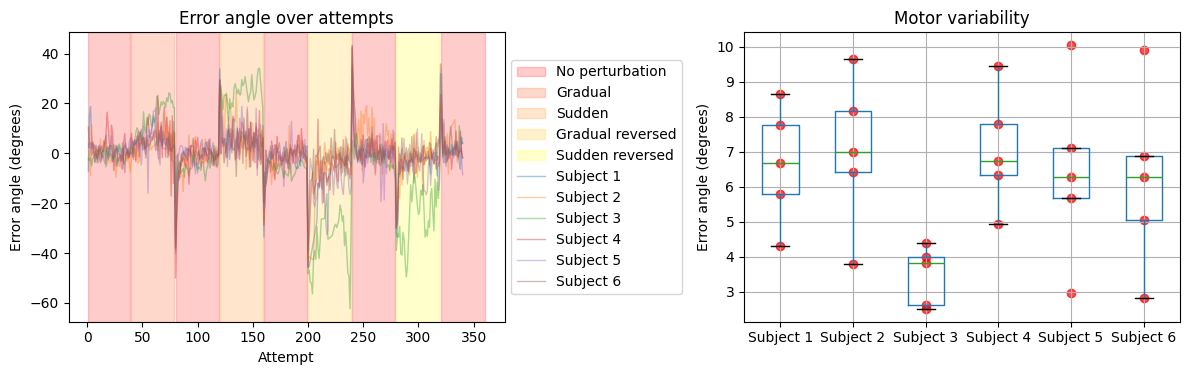

In [109]:
plot_error_angle(subjects, experiment, stats)

### Performing the experiment with _mask_mode = False_

In [110]:
subjects = [preprocess(read_data(file), full_experiment) for file in glob("data/*mask_off.npy")]

# Evaluate subject statistics
stats = []
for i, subject in enumerate(subjects):
    subject_stats = evaluate_statistics(subject)
    subject_stats["Subject"] = f"Subject {i + 1}"
    stats.append(subject_stats)
stats = pd.concat(stats, ignore_index = True)

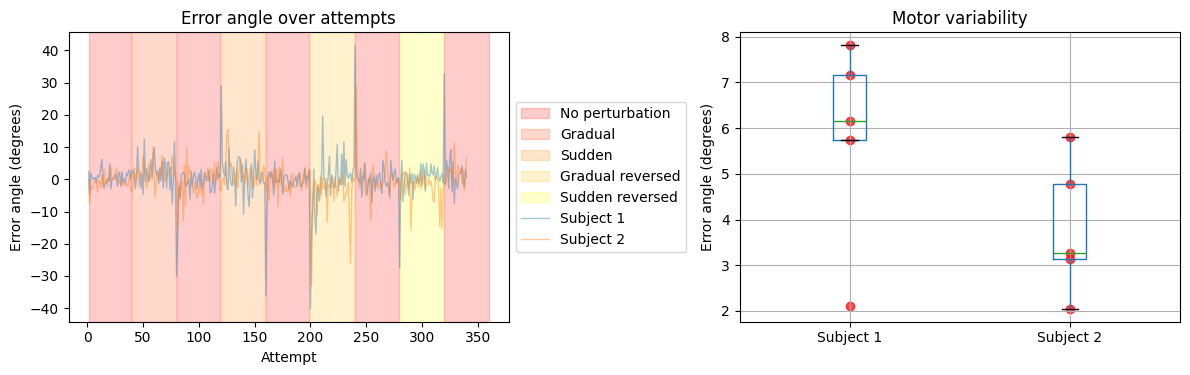

In [111]:
plot_error_angle(subjects, experiment, stats)

## Task 3: Discussion of your results
 
What do you see when perturbation is introduced? Is there an after-effect? What is the difference between gradual and sudden perturbation? Why is it important to mask the last part of the trajectory?

## Task 4: Implementation of our own idea

Our own idea was to is basically just applying the lecture from the 15.01.2025 and reversing the perturbation. Therefor we would like to have seen if the subject is able to recognize the same perturbation but applied now in the other direction. This results in the complete perturbation schedule:
1. No perturbation
2. Gradual
3. No perturbation
4. Sudden
5. No perturbation
6. Gradual reversed
7. No perturbation
8. Sudden reversed
9. No perturbation

So we add two steps of perturbation and arrive at:

```python
if perturbation_mode:
    if perturbation_type == "sudden":
        # sudden clockwise perturbation of perturbation_angle
        # 30 degree
        perturbed_mouse_angle = perturbation_angle

    elif perturbation_type == "gradual":
        # gradual counterclockwise perturbation of perturbation_angle in 10 steps, with perturbation_angle/10, each step lasts 3 attempts
        perturbed_mouse_angle = np.deg2rad(
            ((gradual_attempts // 3) + 1) * np.rad2deg(perturbation_angle) / 10
        )

    if perturbation_type == "sudden_reversed":
        # sudden clockwise perturbation of perturbation_angle
        # 30 degree
        perturbed_mouse_angle = -perturbation_angle

    elif perturbation_type == "gradual_reversed":
        # gradual counterclockwise perturbation of perturbation_angle in 10 steps, with perturbation_angle/10, each step lasts 3 attempts
        perturbed_mouse_angle = -np.deg2rad(
            ((gradual_attempts // 3) + 1) * np.rad2deg(perturbation_angle) / 10
        )

    rot_mat = np.array(
        [
            [np.cos(perturbed_mouse_angle), -np.sin(perturbed_mouse_angle)],
            [np.sin(perturbed_mouse_angle), np.cos(perturbed_mouse_angle)],
        ]
    )
```

As we can see in the masked plot there are a couple of similarities like the overcorrection after going back into the unperturbed state but now the other way around and also the annealing error before going into the next kind of perturbation but again also from the other side but also with a comparable amplitude. 

Differences are clearly in the gradual reversed perturbation. The perturbation for the normal gradual case is increasing slowly until the end of this step but for the gradual reversed step it is very high in the beginning but decreases until the end. Therefore you could infer a learning effect about the gradual perturbation or it could also be easier to adjust to a perturbation which requires you to go to the left with your right hand because all subjects use the right hand to move the mouse.  
Further we notice a similar curve form for the sudden reversed perturbation but with less standard deviation (besides the outlier of subject 3).